In [1]:
import openeo
from matplotlib import pyplot as plt
import rasterio.plot
import io
import tarfile
import numpy as np
import glob
import re
import os
import xarray as xr
import torch
import functions.handy_functions as hf

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

2024-05-11 12:05:26.865098: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-11 12:05:26.899312: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-11 12:05:26.899330: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-11 12:05:26.900238: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-11 12:05:26.905864: I tensorflow/core/platform/cpu_feature_guar

In [2]:
#Set directory of found pairs
main_dir='/cloud/skogsstyrelsen_pairs/'
directories=os.listdir(main_dir)

In [3]:
#Import and format data
ims_all=[]
temporals_all=[]
for dir in directories:
    data_clear=xr.load_dataset(main_dir+dir+'/clear_data.nc', engine='netcdf4', decode_times=True)
    data_cloudy=xr.load_dataset(main_dir+dir+'/cloudy_data.nc', engine='netcdf4', decode_times=True)

    variables=data_clear.variables

    ## Get bands ##
    b02=variables['b02'].data
    b03=variables['b03'].data
    b04=variables['b04'].data
    b05=variables['b05'].data
    b06=variables['b06'].data
    b07=variables['b07'].data
    b08=variables['b08'].data
    b8a=variables['b8a'].data
    b09=variables['b09'].data
    b10=variables['b10'].data
    b11=variables['b11'].data
    b12=variables['b12'].data
    sun_z=variables['sun_zenith_angle'].data

    ## Save image ##
    im_clear=np.zeros((np.shape(b03)[0],np.shape(b03)[1],13))
    im_clear[:,:,0]=b02
    im_clear[:,:,1]=b03
    im_clear[:,:,2]=b04
    im_clear[:,:,3]=b05
    im_clear[:,:,4]=b06
    im_clear[:,:,5]=b07
    im_clear[:,:,6]=b08
    im_clear[:,:,7]=b8a
    im_clear[:,:,8]=b09
    im_clear[:,:,9]=b10
    im_clear[:,:,10]=b11
    im_clear[:,:,11]=b12
    im_clear[:,:,12]=sun_z

    variables=data_cloudy.variables

    ## Get bands ##
    b02=variables['b02'].data
    b03=variables['b03'].data
    b04=variables['b04'].data
    b05=variables['b05'].data
    b06=variables['b06'].data
    b07=variables['b07'].data
    b08=variables['b08'].data
    b8a=variables['b8a'].data
    b09=variables['b09'].data
    b10=variables['b10'].data
    b11=variables['b11'].data
    b12=variables['b12'].data
    sun_z=variables['sun_zenith_angle'].data

    ## Save image ##
    im_cloudy=np.zeros((np.shape(b03)[0],np.shape(b03)[1],13))
    im_cloudy[:,:,0]=b02
    im_cloudy[:,:,1]=b03
    im_cloudy[:,:,2]=b04
    im_cloudy[:,:,3]=b05
    im_cloudy[:,:,4]=b06
    im_cloudy[:,:,5]=b07
    im_cloudy[:,:,6]=b08
    im_cloudy[:,:,7]=b8a
    im_cloudy[:,:,8]=b09
    im_cloudy[:,:,9]=b10
    im_cloudy[:,:,10]=b11
    im_cloudy[:,:,11]=b12
    im_cloudy[:,:,12]=sun_z

    im_pair=[im_clear,im_cloudy]
    ims_all.append(im_pair)
    temporals_all.append([data_clear.coords['t'].data[0],data_cloudy.coords['t'].data[0]])

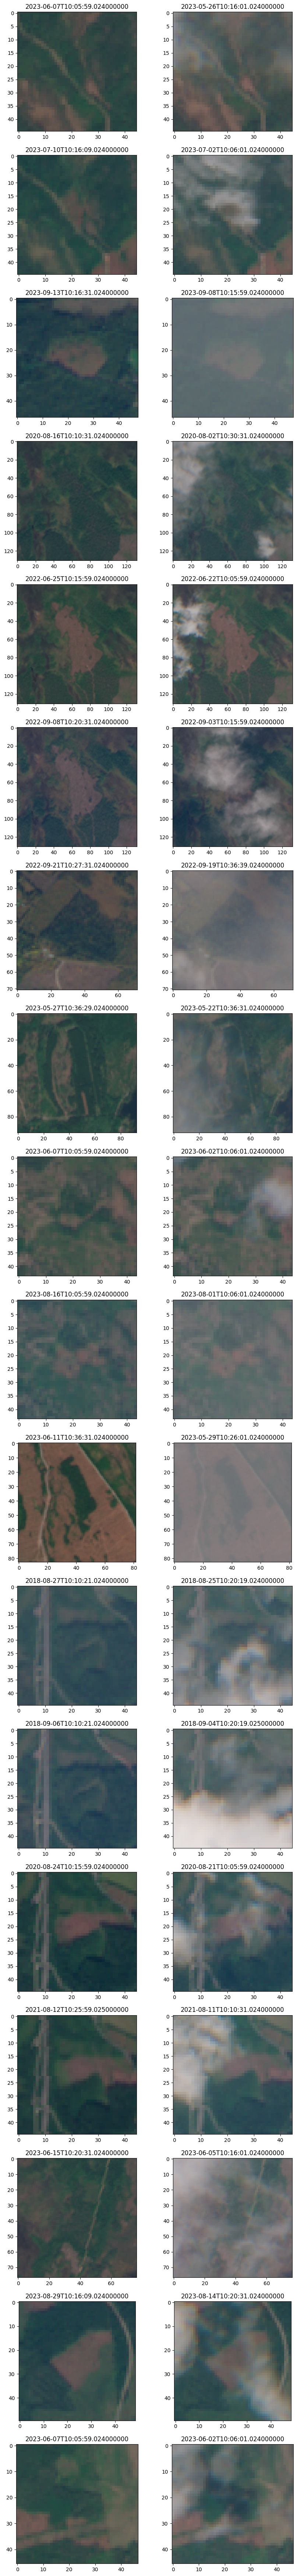

In [4]:
#Plot all clear/cloudy pairs
ncols=2
nrows=len(ims_all)

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

pair_c=0
for i,pair in enumerate(ims_all):

    im_clear=pair[0]
    im_cloud=pair[1]

    axs[pair_c,0].imshow(hf.Sentinel2TrueColor(im_clear))
    axs[pair_c,0].set_title(temporals_all[i][0])
    axs[pair_c,1].imshow(hf.Sentinel2TrueColor(im_cloud))
    axs[pair_c,1].set_title(temporals_all[i][1])
    pair_c+=1

In [5]:
#Load tuned model
main_filepath='pytorch_models/Ultimate_model'
n_ensemble=5
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))

quantiles = np.array([0.1,0.5,0.9])
est = np.where(quantiles==0.5)[0].item()
 

In [6]:
#Make predictions and save with uncertanties

preds_all=[]
uncertainties_all=[]
lower_all=[]
higher_all=[]
for i,pair in enumerate(ims_all):
    im_cloud=pair[1]

    ## Reshape cloudy data
    im_shape=np.shape(im_cloud)
    im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
    for i in range(im_shape[2]):
        im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

    ## Make prediction
    for i,model in enumerate(models):
        if i==0:
            pred=model.predict(im_cloud_r)
        else:   
            pred=pred+model.predict(im_cloud_r)
    pred=pred/len(models)

    #Reshape back
    im_shape_pred=(im_shape[0],im_shape[1],12)
    im_pred=np.zeros(im_shape_pred)
    im_unc=np.zeros(im_shape_pred)
    im_lower=np.zeros(im_shape_pred)
    im_higher=np.zeros(im_shape_pred)   
    for i in range(im_shape_pred[2]):
        im_pred[:,:,i]=np.reshape(pred[:,i,est],im_shape_pred[0:2])
        im_unc[:,:,i]=np.reshape(pred[:,i,-1]-pred[:,i,0],im_shape_pred[0:2])
        im_lower[:,:,i]=np.reshape(pred[:,i,0],im_shape_pred[0:2])
        im_higher[:,:,i]=np.reshape(pred[:,i,-1],im_shape_pred[0:2])

    preds_all.append(im_pred)
    uncertainties_all.append(im_unc)
    lower_all.append(im_lower)
    higher_all.append(im_higher)

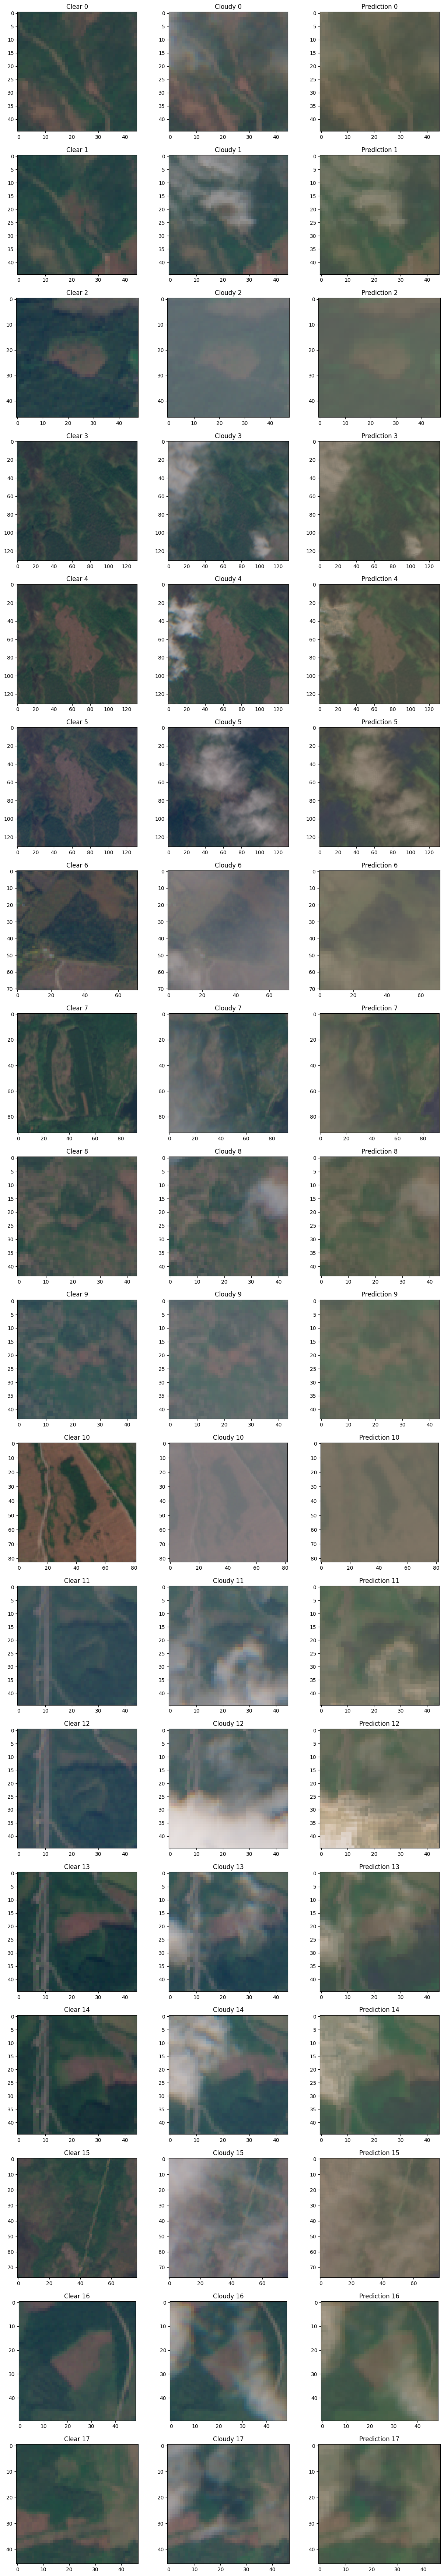

In [7]:
#Print clear, cloudy and predictions
ncols=3
nrows=len(ims_all)

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

pair_c=0
for i,pair in enumerate(ims_all):

    im_clear=pair[0]
    im_cloud=pair[1]

    axs[pair_c,0].imshow(hf.Sentinel2TrueColor(im_clear))
    axs[pair_c,0].set_title('Clear %i'%pair_c)
    axs[pair_c,1].imshow(hf.Sentinel2TrueColor(im_cloud))
    axs[pair_c,1].set_title('Cloudy %i'%pair_c)
    axs[pair_c,2].imshow(hf.Sentinel2TrueColor(preds_all[i]))
    axs[pair_c,2].set_title('Prediction %i'%pair_c)
    pair_c+=1

In [8]:
#Evaluate through NMSE

n_pairs=len(preds_all)

NMSEs_og=np.zeros((n_pairs,12))
NMSEs_pred=np.zeros((n_pairs,12))

p_c=0
for i,pair in enumerate(ims_all):

    im_cloud=pair[1]
    im_clear=pair[0]
    im_pred=preds_all[i]

    #np.linal.norm() -> Frobenius norm i.e root of the sum of squares
    norm_og=np.linalg.norm((im_clear[:,:,0:12])-(im_cloud[:,:,0:12]),axis=(0,1))**2
    norm_pred=np.linalg.norm((im_clear[:,:,0:12])-im_pred[:,:,0:12],axis=(0,1))**2
    norm_gt=np.linalg.norm(im_clear[:,:,0:12],axis=(0,1))**2

    NMSE_og=norm_og/norm_gt
    NMSE_pred=norm_pred/norm_gt

    NMSEs_og[p_c,:]=NMSE_og
    NMSEs_pred[p_c,:]=NMSE_pred
    p_c+=1

mean_NMSE_og=np.mean(NMSEs_og,axis=0)
mean_NMSE_pred=np.mean(NMSEs_pred,axis=0)

mean_NMSE_og_wo_10=np.concatenate((mean_NMSE_og[0:9],mean_NMSE_og[10:]),axis=0)
mean_NMSE_pred_wo_10=np.concatenate((mean_NMSE_pred[0:9],mean_NMSE_pred[10:]),axis=0)

for i in range(len(mean_NMSE_og)):
    if i<=6:
        print('NMSE before correction, Band '+str(i+2)+': '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+2)+': '+str(mean_NMSE_pred[i]))
    elif i==7:
        print('NMSE before correction, Band '+str(i+1)+'A: '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+'A: '+str(mean_NMSE_pred[i]))
    else:
        print('NMSE before correction, Band '+str(i+1)+': '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+': '+str(mean_NMSE_pred[i]))    

    print(' ')

print('Mean NMSE before correction: '+str(np.mean(mean_NMSE_og)))
print('Mean NMSE after correction: '+str(np.mean(mean_NMSE_pred)))    

print(' ')

print('Mean NMSE before correction, without band 10: '+str(np.mean(mean_NMSE_og_wo_10)))
print('Mean NMSE after correction, without band 10: '+str(np.mean(mean_NMSE_pred_wo_10)))


NMSE before correction, Band 2: 0.40022542608828293
NMSE after correction, Band 2: 0.08994347374571202
 
NMSE before correction, Band 3: 0.6212890787256616
NMSE after correction, Band 3: 0.2829114441673566
 
NMSE before correction, Band 4: 1.5116504378187048
NMSE after correction, Band 4: 0.8147302850593025
 
NMSE before correction, Band 5: 0.7250211653587733
NMSE after correction, Band 5: 0.4274460510606133
 
NMSE before correction, Band 6: 0.18495176309883093
NMSE after correction, Band 6: 0.1608467691433735
 
NMSE before correction, Band 7: 0.14537585927097002
NMSE after correction, Band 7: 0.11243995294471246
 
NMSE before correction, Band 8: 0.1327387139056492
NMSE after correction, Band 8: 0.09946087986624524
 
NMSE before correction, Band 8A: 0.12652202716872862
NMSE after correction, Band 8A: 0.07466151452445857
 
NMSE before correction, Band 9: 0.6173873387396649
NMSE after correction, Band 9: 0.4357668403955956
 
NMSE before correction, Band 10: 1.8206887445567332
NMSE after 

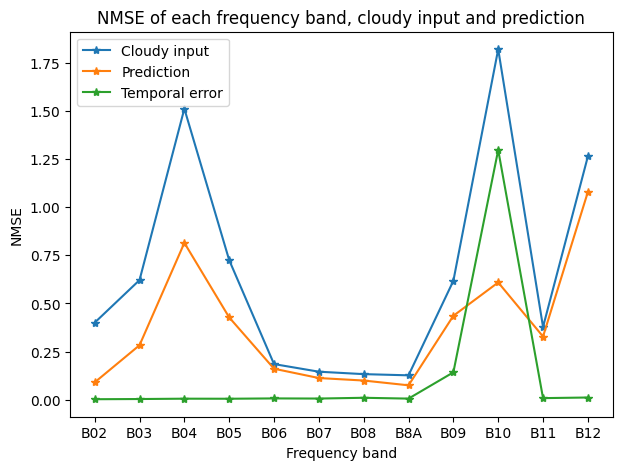

In [9]:
temp_bias = np.array([0.0024,0.0034,0.0052,0.0049,0.0066,0.0059,0.0099,0.0056,0.1421,1.2973,0.0081,0.0113])


bands=np.array([0,1,2,3,4,5,6,7,8,9,10,11])
x=np.arange(np.size(bands))

plt.rcParams['figure.figsize'] = [7, 5]

plt.figure()
plt.plot(x,mean_NMSE_og[bands],'-*')
plt.plot(x,mean_NMSE_pred[bands],'-*')
plt.plot(x,temp_bias[bands],'-*')
plt.xticks(x, ['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
plt.xlabel('Frequency band')
plt.ylabel('NMSE')
plt.legend(['Cloudy input','Prediction','Temporal error'],loc='upper left')

plt.title('NMSE of each frequency band, cloudy input and prediction')
plt.show()

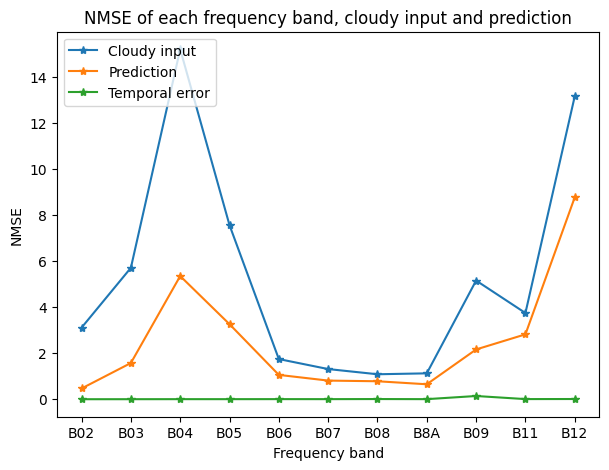

In [10]:
pair_no=12

bands=np.array([0,1,2,3,4,5,6,7,8,10,11])

bandnames=np.array(['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
x=np.arange(np.size(bands))

plt.rcParams['figure.figsize'] = [7, 5]

plt.figure()
plt.plot(x,NMSEs_og[pair_no,bands],'-*')
plt.plot(x,NMSEs_pred[pair_no,bands],'-*')
plt.plot(x,temp_bias[bands],'-*')
plt.xticks(x, bandnames[bands])
plt.xlabel('Frequency band')
plt.ylabel('NMSE')
plt.legend(['Cloudy input','Prediction','Temporal error'],loc='upper left')

plt.title('NMSE of each frequency band, cloudy input and prediction')
plt.show()

In [11]:
clear_r = np.array([], dtype=np.int64).reshape(0,12)
cloud_r = np.array([], dtype=np.int64).reshape(0,12)
pred_r = np.array([], dtype=np.int64).reshape(0,12)
lower_r = np.array([], dtype=np.int64).reshape(0,12)
higher_r = np.array([], dtype=np.int64).reshape(0,12)
unc_r = np.array([], dtype=np.int64).reshape(0,12)

for i,pair in enumerate(ims_all):
    im_clear=pair[0]
    im_cloud=pair[1]
    im_pred=preds_all[i]
    im_lower=lower_all[i]
    im_higher=higher_all[i]
    im_unc=uncertainties_all[i]

    ## Reshape clear data
    im_shape=np.shape(im_pred)
    im_clear_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
    for i in range(im_shape[2]):
        im_clear_r[:,i]=np.reshape(im_clear[:,:,i],im_shape[0]*im_shape[1])

    ## Reshape cloud data
    im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
    for i in range(im_shape[2]):
        im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

    ## Reshape pred data
    im_pred_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
    for i in range(im_shape[2]):
        im_pred_r[:,i]=np.reshape(im_pred[:,:,i],im_shape[0]*im_shape[1])

    ## Reshape lower data
    im_lower_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
    for i in range(im_shape[2]):
        im_lower_r[:,i]=np.reshape(im_lower[:,:,i],im_shape[0]*im_shape[1])

    ## Reshape higher data
    im_higher_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
    for i in range(im_shape[2]):
        im_higher_r[:,i]=np.reshape(im_higher[:,:,i],im_shape[0]*im_shape[1])

    ## Reshape unc data
    im_unc_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
    for i in range(im_shape[2]):
        im_unc_r[:,i]=np.reshape(im_unc[:,:,i],im_shape[0]*im_shape[1])

    clear_r=np.vstack([clear_r, im_clear_r])
    cloud_r=np.vstack([cloud_r, im_cloud_r])
    pred_r=np.vstack([pred_r, im_pred_r])
    lower_r=np.vstack([lower_r, im_lower_r])
    higher_r=np.vstack([higher_r, im_higher_r])
    unc_r=np.vstack([unc_r, im_unc_r])

gigapred=np.stack((lower_r,pred_r,higher_r),axis=2)

In [12]:
def quant_rate_bands(y_true,y_pred):
    quantcount = np.zeros([np.shape(y_pred)[1],np.shape(y_pred)[2]])
    for i in range(np.shape(y_pred)[0]):
        for j in range(np.shape(y_pred)[1]):
            for k in range(np.shape(y_pred)[2]):
                if y_true[i,j] < y_pred[i,j,k]:
                    quantcount[j,k] = quantcount[j,k] + 1 

    quantrate = quantcount/np.shape(y_true)[0]

    return quantrate

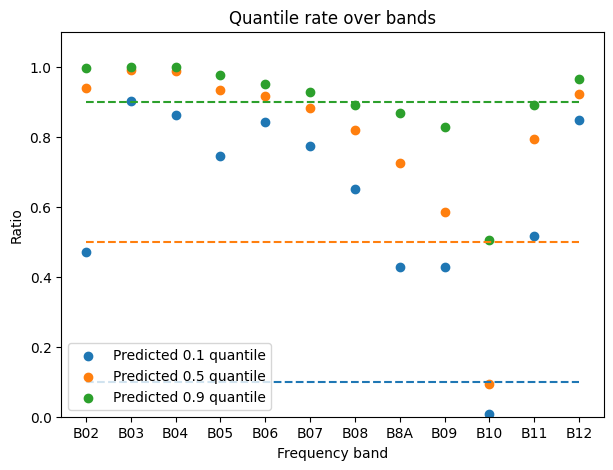

In [13]:

Quant_rates = quant_rate_bands(clear_r,gigapred)

bands=np.array([0,1,2,3,4,5,6,7,8,9,10,11])
x=np.arange(np.size(bands))
plt.figure()

#plt.plot(np.array([0,11]),np.array([0.1,0.1]))
#plt.plot(np.array([0,11]),np.array([0.5,0.5]))
#plt.plot(np.array([0,11]),np.array([0.9,0.9]))

for quant in range(len(quantiles)):
    plt.plot(np.array([bands[0],bands[-1]]),np.array([quantiles[quant],quantiles[quant]]),'--')
    plt.scatter(x,Quant_rates[:,quant],label='Predicted %s quantile'%str(quantiles[quant]))

plt.xticks(x, ['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
plt.title('Quantile rate over bands')
plt.xlabel('Frequency band')
plt.ylabel('Ratio')
plt.legend(loc='lower left')
plt.ylim([0,1.1])
plt.show()

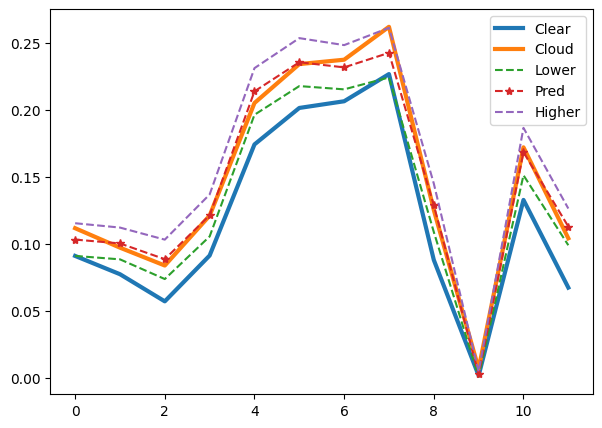

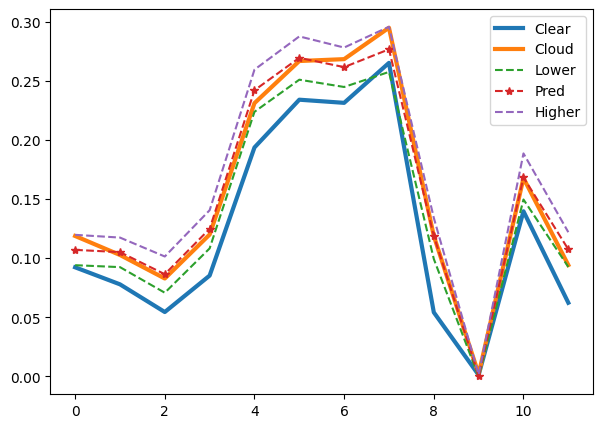

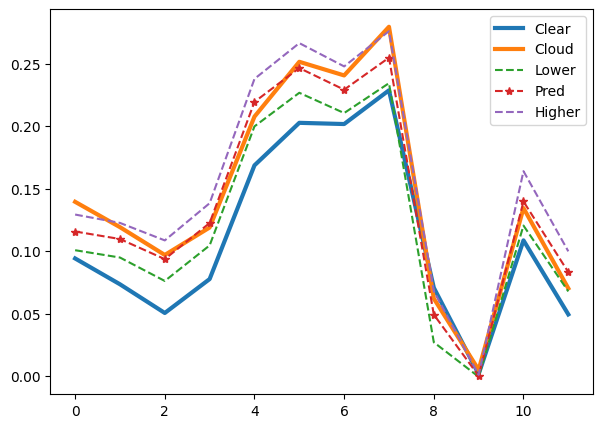

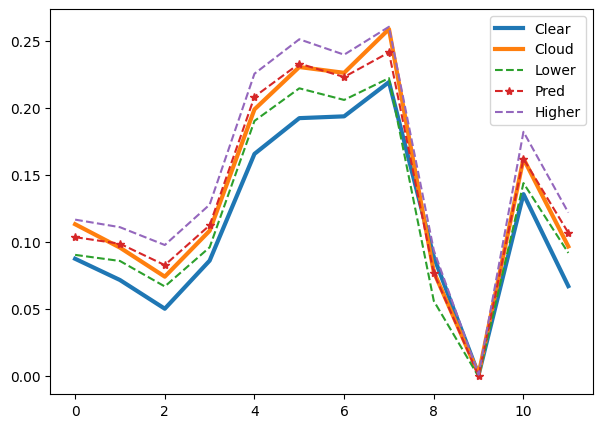

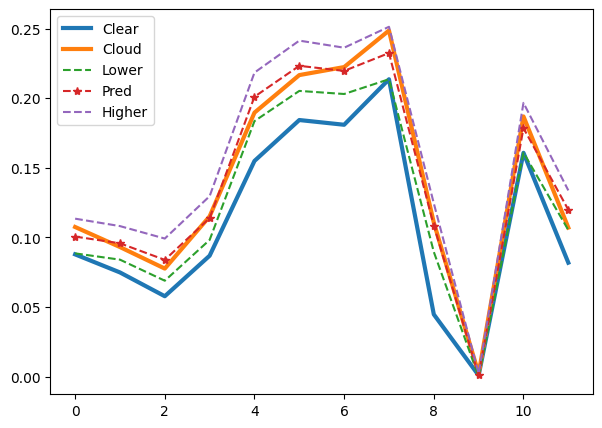

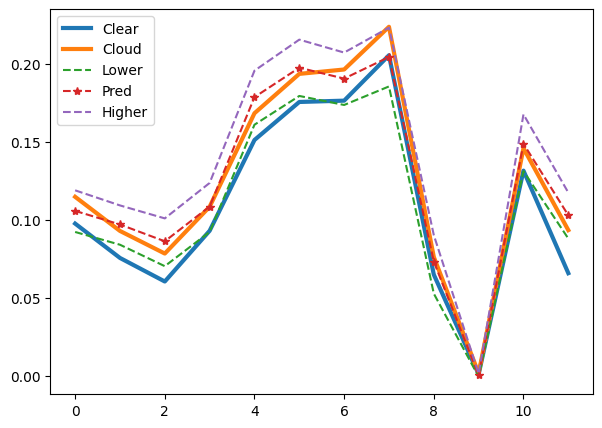

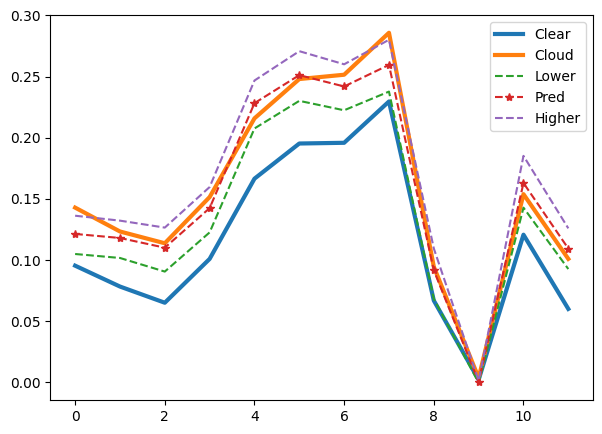

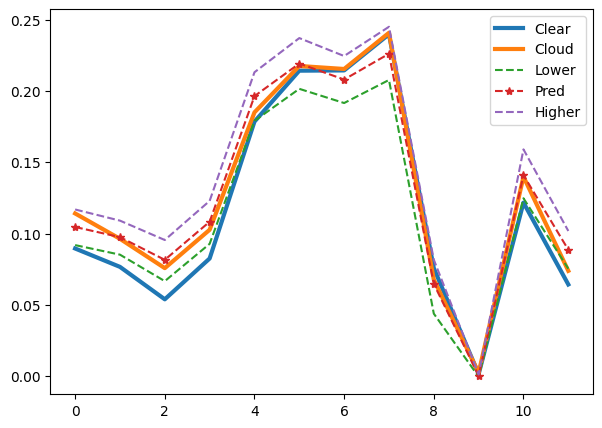

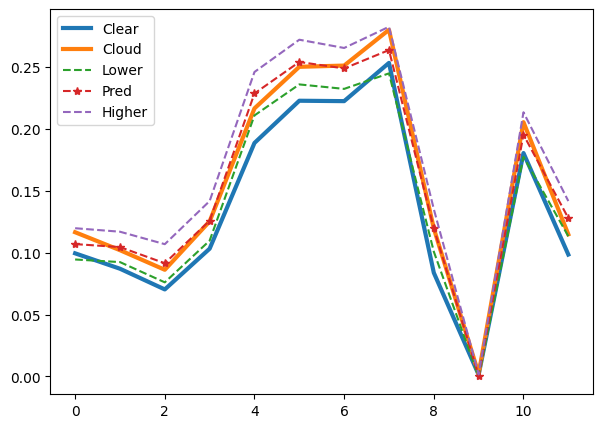

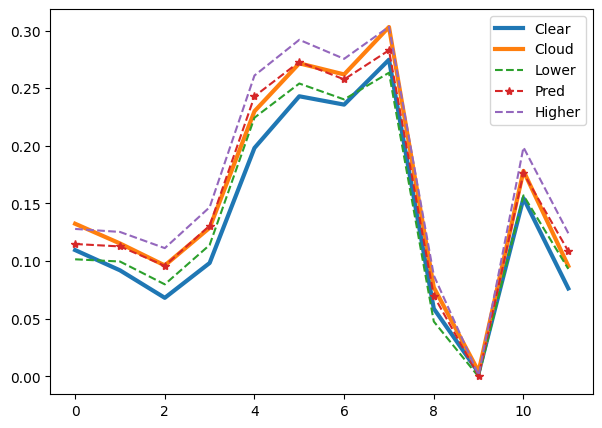

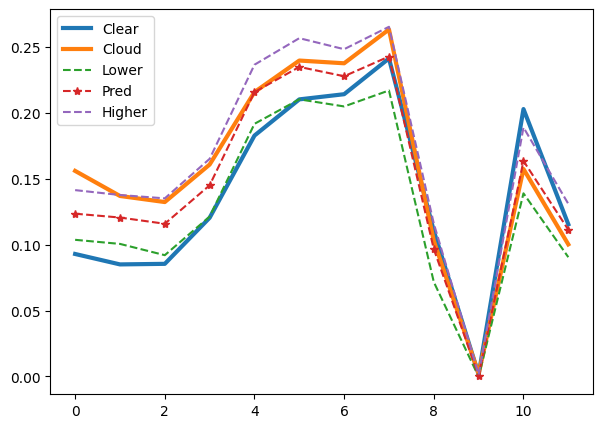

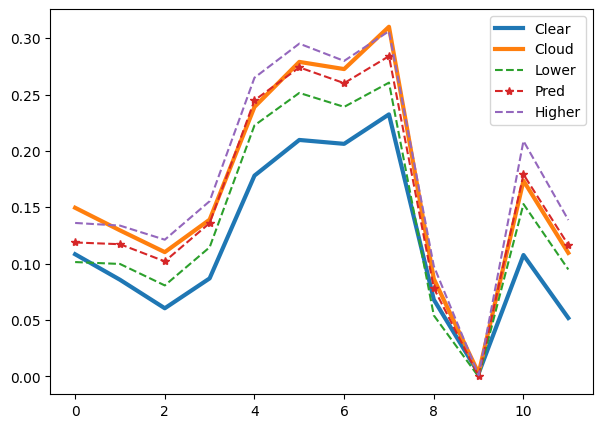

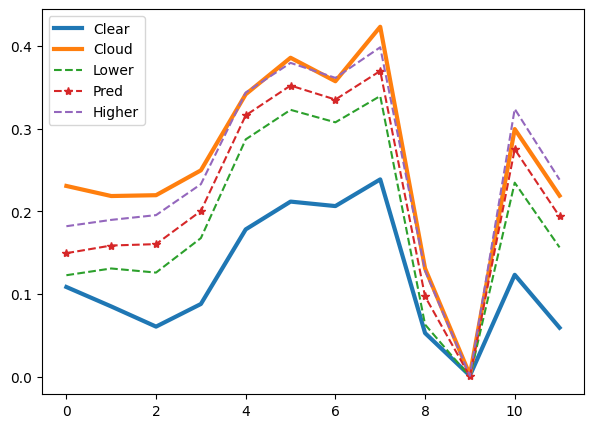

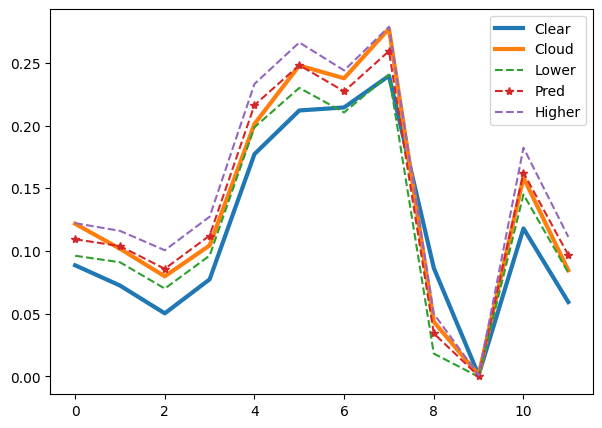

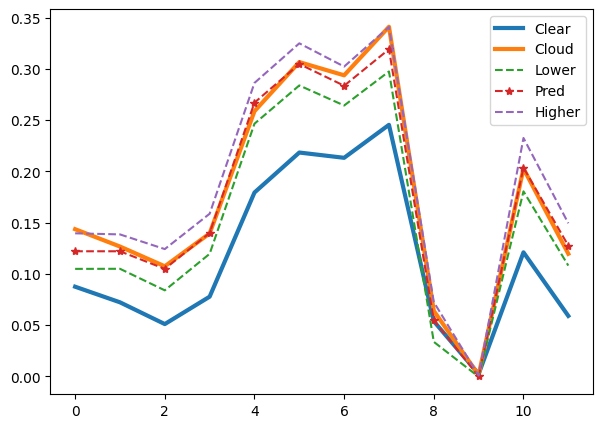

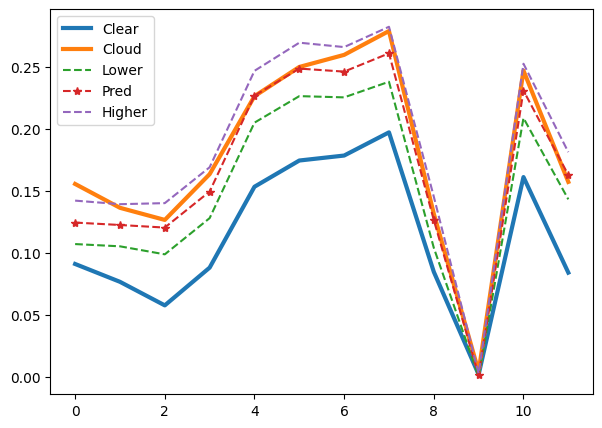

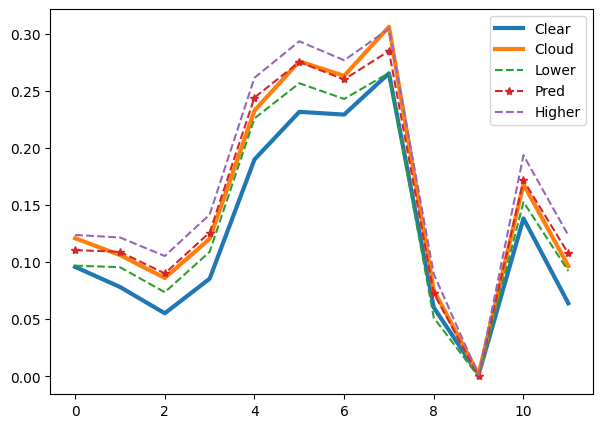

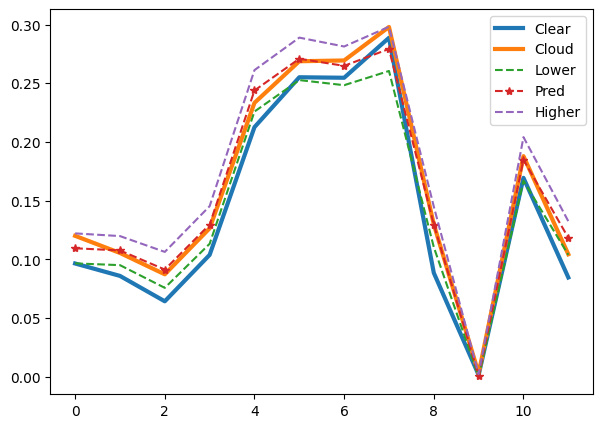

In [17]:
x=np.array([0,1,2,3,4,5,6,7,8,9,10,11])

for i,pair in enumerate(ims_all):
    im_clear=pair[0]
    im_cloud=pair[1]
    im_pred=preds_all[i]
    im_lower=lower_all[i]
    im_higher=higher_all[i]

    plt.figure()
    plt.plot(x,np.mean(im_clear[:,:,:12],axis=(0,1)),label='Clear',linewidth=3)
    plt.plot(x,np.mean(im_cloud[:,:,:12],axis=(0,1)),label='Cloud',linewidth=3)
    plt.plot(x,np.mean(im_lower[:,:,:12],axis=(0,1)),'--',label='Lower')
    plt.plot(x,np.mean(im_pred[:,:,:12],axis=(0,1)),'--*',label='Pred')
    plt.plot(x,np.mean(im_higher[:,:,:12],axis=(0,1)),'--',label='Higher')
    plt.legend()
    plt.show()

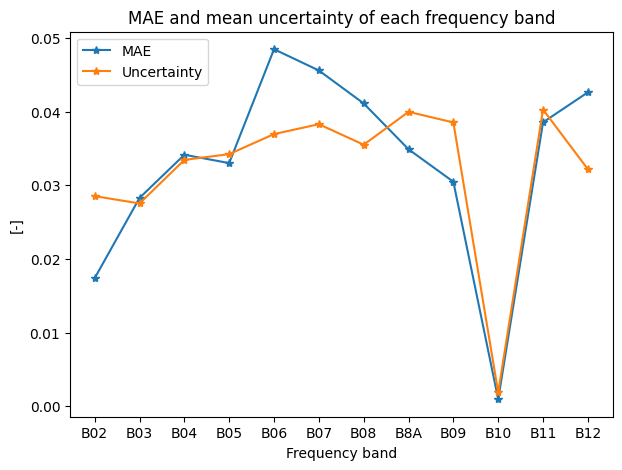

(101262,)
(101262,)
1.2440905150093138
PearsonRResult(statistic=0.7643304638332291, pvalue=0.0)


In [23]:
bands=np.array([0,1,2,3,4,5,6,7,8,9,10,11])
x=np.arange(np.size(bands))

plt.rcParams['figure.figsize'] = [7, 5]

plt.figure()
plt.plot(x,np.mean(np.abs(clear_r-pred_r),axis=0),'-*')
plt.plot(x,np.mean(unc_r,axis=0),'-*')
plt.xticks(x, ['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
plt.xlabel('Frequency band')
plt.ylabel('[-]')
plt.legend(['MAE','Uncertainty'],loc='upper left')

plt.title('MAE and mean uncertainty of each frequency band')
plt.show()

abs_errors = np.mean(np.abs(clear_r-pred_r),axis=1)
uncs = np.mean(unc_r,axis=1)
print(abs_errors.shape)
print(uncs.shape)
print(np.mean(uncs/abs_errors))

import scipy
print(scipy.stats.pearsonr(abs_errors,uncs))

Thin cloud case studies:

0
1
2
3


'\naxs[0,0].plot([xbox1[0],xbox1[1],xbox1[1],xbox1[0],xbox1[0]],[ybox1[0],ybox1[0],ybox1[1],ybox1[1],ybox1[0]])\naxs[0,1].plot([xbox1[0],xbox1[1],xbox1[1],xbox1[0],xbox1[0]],[ybox1[0],ybox1[0],ybox1[1],ybox1[1],ybox1[0]])\naxs[1,0].plot([xbox2[0],xbox2[1],xbox2[1],xbox2[0],xbox2[0]],[ybox2[0],ybox2[0],ybox2[1],ybox2[1],ybox2[0]])\naxs[1,1].plot([xbox2[0],xbox2[1],xbox2[1],xbox2[0],xbox2[0]],[ybox2[0],ybox2[0],ybox2[1],ybox2[1],ybox2[0]])\naxs[2,0].plot([xbox3[0],xbox3[1],xbox3[1],xbox3[0],xbox3[0]],[ybox3[0],ybox3[0],ybox3[1],ybox3[1],ybox3[0]])\naxs[2,1].plot([xbox3[0],xbox3[1],xbox3[1],xbox3[0],xbox3[0]],[ybox3[0],ybox3[0],ybox3[1],ybox3[1],ybox3[0]])\naxs[3,0].plot([xbox4[0],xbox4[1],xbox4[1],xbox4[0],xbox4[0]],[ybox4[0],ybox4[0],ybox4[1],ybox4[1],ybox4[0]])\naxs[3,1].plot([xbox4[0],xbox4[1],xbox4[1],xbox4[0],xbox4[0]],[ybox4[0],ybox4[0],ybox4[1],ybox4[1],ybox4[0]])\n'

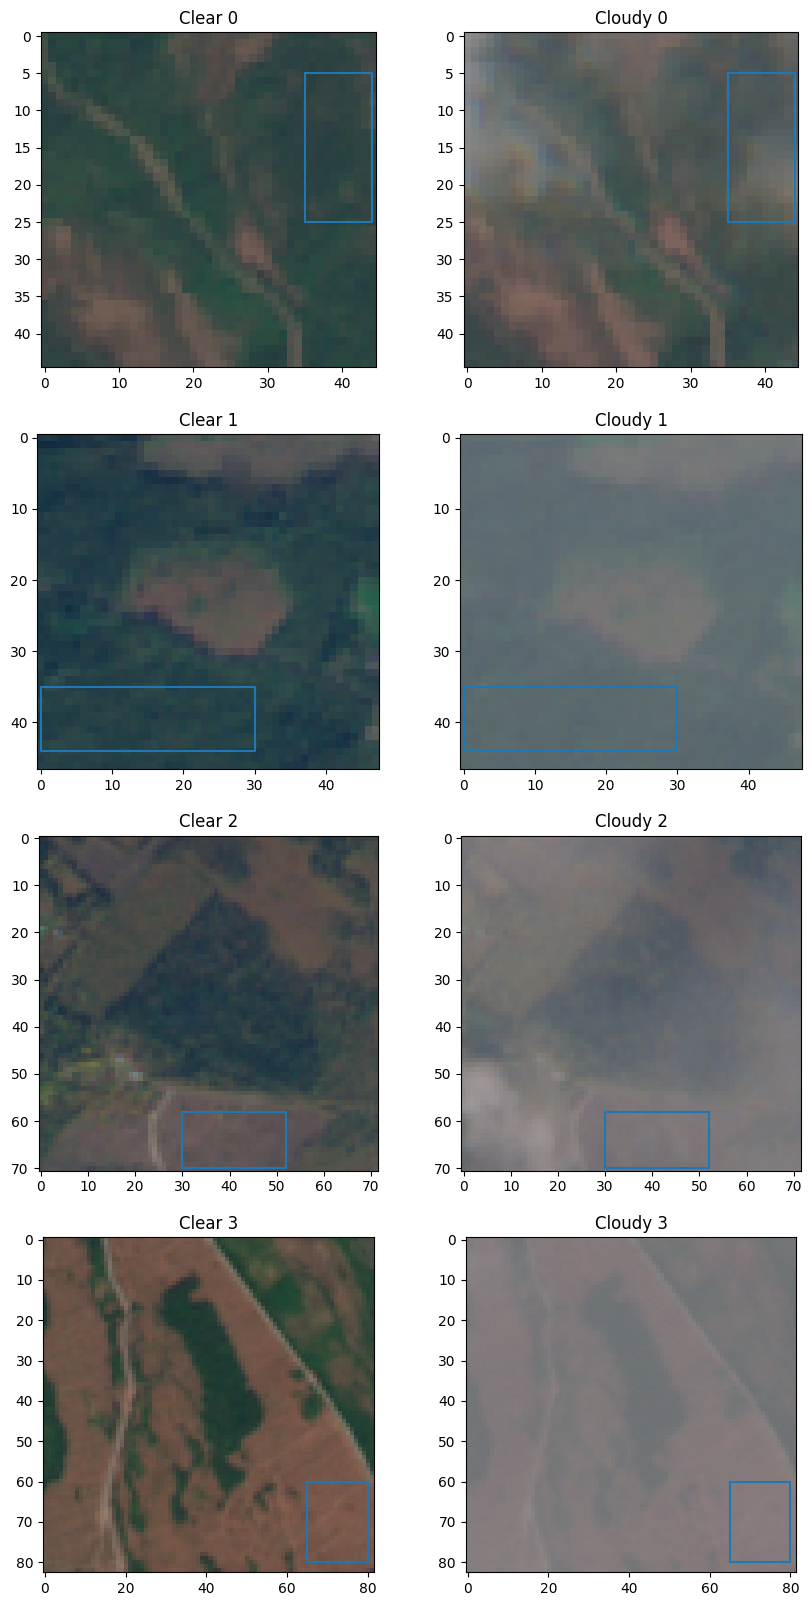

In [51]:
thin_pairs=[0,2,6,10]

box1= np.array([[35,44],[5,25]])
box2= np.array([[0,30],[35,44]])
box3= np.array([[30,52],[58,70]])
box4= np.array([[65,80],[60,80]])

thin_boxes=[]
thin_boxes.append(box1)
thin_boxes.append(box2)
thin_boxes.append(box3)
thin_boxes.append(box4)



#Print clear, cloudy and predictions
ncols=2
nrows=len(thin_pairs)

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

pair_c=0
for i,pair in enumerate(thin_pairs):
    pair = ims_all[pair]
    im_clear=pair[0]
    im_cloud=pair[1]
    box=thin_boxes[i]

    axs[pair_c,0].imshow(hf.Sentinel2TrueColor(im_clear))
    axs[pair_c,0].plot([box[0,0],box[0,1],box[0,1],box[0,0],box[0,0]],[box[1,0],box[1,0],box[1,1],box[1,1],box[1,0]])
    axs[pair_c,0].set_title('Clear %i'%pair_c)
    axs[pair_c,1].imshow(hf.Sentinel2TrueColor(im_cloud))
    axs[pair_c,1].plot([box[0,0],box[0,1],box[0,1],box[0,0],box[0,0]],[box[1,0],box[1,0],box[1,1],box[1,1],box[1,0]])
    axs[pair_c,1].set_title('Cloudy %i'%pair_c)
    pair_c+=1


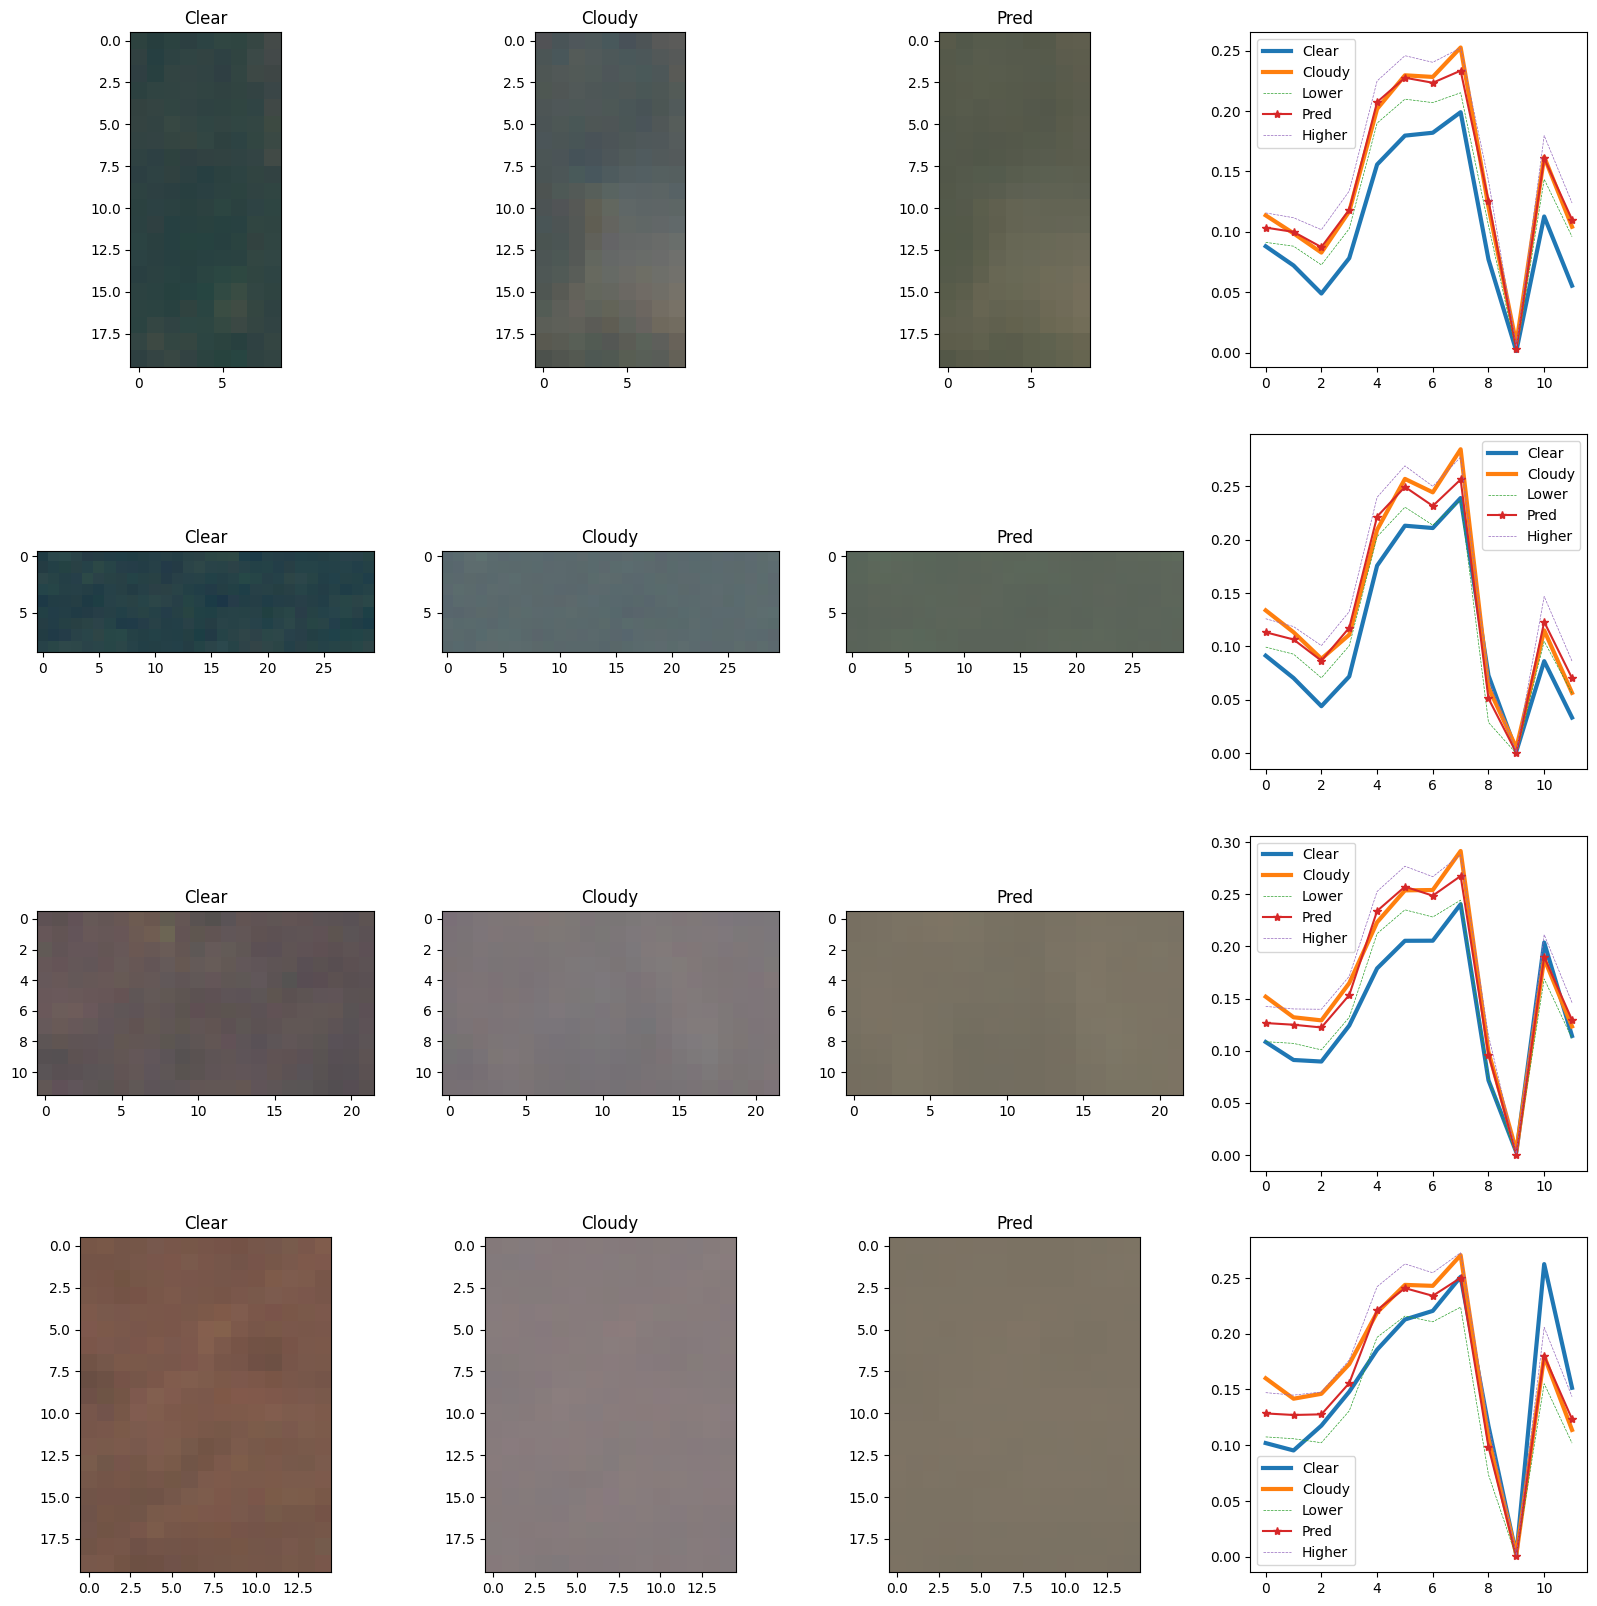

In [62]:

#Print clear, cloudy and predictions
ncols=4
nrows=len(thin_pairs)

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)


pair_c=0
for i,img in enumerate(thin_pairs):
    pair = ims_all[img]
    im_clear=pair[0]
    im_cloud=pair[1]
    im_pred=preds_all[img]
    im_lower=lower_all[img]
    im_higher=higher_all[img]
    box=thin_boxes[i]

    clear_box=im_clear[box[1,0]:box[1,1],box[0,0]:box[0,1],:]
    cloud_box=im_cloud[box[1,0]:box[1,1],box[0,0]:box[0,1],:]
    pred_box=im_pred[box[1,0]:box[1,1],box[0,0]:box[0,1],:]
    lower_box=im_lower[box[1,0]:box[1,1],box[0,0]:box[0,1],:]
    higher_box=im_higher[box[1,0]:box[1,1],box[0,0]:box[0,1],:]

    axs[pair_c,0].imshow(hf.Sentinel2TrueColor(clear_box))
    axs[pair_c,0].set_title('Clear')
    axs[pair_c,1].imshow(hf.Sentinel2TrueColor(cloud_box))
    axs[pair_c,1].set_title('Cloudy')
    axs[pair_c,2].imshow(hf.Sentinel2TrueColor(pred_box))
    axs[pair_c,2].set_title('Pred')
    axs[pair_c,3].plot(np.arange(12),np.mean(clear_box[:,:,:12],axis=(0,1)),linewidth=3,label='Clear')
    axs[pair_c,3].plot(np.arange(12),np.mean(cloud_box[:,:,:12],axis=(0,1)),linewidth=3,label='Cloudy')
    axs[pair_c,3].plot(np.arange(12),np.mean(lower_box[:,:,:12],axis=(0,1)),'--',linewidth=0.5,label='Lower')
    axs[pair_c,3].plot(np.arange(12),np.mean(pred_box[:,:,:12],axis=(0,1)),'-*',label='Pred')
    axs[pair_c,3].plot(np.arange(12),np.mean(higher_box[:,:,:12],axis=(0,1)),'--',linewidth=0.5,label='Higher')
    axs[pair_c,3].legend()
    pair_c+=1    


In [54]:
np.shape(preds_all[0])

(45, 45, 12)